Credit: https://num.pyro.ai/en/stable/tutorials/bayesian_hierarchical_linear_regression.html

In [71]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from numpyro.infer import MCMC, NUTS, Predictive
from jax import random
import numpyro
import numpyro.distributions as dist
import jax.numpy as jnp

In [50]:
data = pd.read_csv(
    "https://gist.githubusercontent.com/ucals/"
    "2cf9d101992cb1b78c2cdd6e3bac6a4b/raw/"
    "43034c39052dcf97d4b894d2ec1bc3f90f3623d9/"
    "osic_pulmonary_fibrosis.csv"
)
data.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


Goal: Predict every patient's FVC for every week in the interval [-12, 133] and the confidence for each prediction.

<h1> Define the Model </h1>

We will use partial pooling. Each patient's FVC value can be used to improve the estimates of the other patient FVC values, but at the same time, we do not want to group all the patients together and assume there is no variation among them.

The chosen prior:
$$ \mu_a \sim N(0, 500)$$
$$ \sigma_a \sim \text{Half-Normal}(100)$$
$$ \mu_b \sim N(0, 3)$$
$$ \sigma_b \sim \text{Half-Normal}(3)$$
$$ a_i \sim N(\mu_a, \sigma_a)$$
$$ b_i \sim N(\mu_b, \sigma_b)$$
$$\sigma \sim \text{Half-Normal}(100)$$
$$FVC_{ij} \sim N(a_i + t b_i, \sigma)$$
where $t$ = time in weeks, $j$ = week index $\in (-12, ..., 133)$, and $i$ = patient index $\in (1, ..., 176)$.

In [30]:
def hierarchical_linear_model(patient_index, weeks, FVC_obs = None):
    '''
    Parameters:
       array patient_id: patient indices
       array weeks: week number
       array FVC_obs: the observed FVC 
    '''
    mu_a = numpyro.sample("mu_a", dist.Normal(0, 500))
    sigma_a = numpyro.sample("sigma_a", dist.HalfNormal(100))
    mu_b = numpyro.sample("mu_b", dist.Normal(0, 3))
    sigma_b = numpyro.sample("sigma_b", dist.HalfNormal(3))
    
    with numpyro.plate("data plate", len(np.unique(patient_index))):
        a = numpyro.sample("a", dist.Normal(mu_a, sigma_a))
        b = numpyro.sample("b", dist.Normal(mu_b, sigma_b))
        
    sigma = numpyro.sample("sigma", dist.HalfNormal(100))
    numpyro.sample("obs", dist.Normal(a[patient_index] + b[patient_index]*weeks, sigma), obs=FVC_obs)

`numpyro.plate` allows us to sample $n$ independent variables in parallel. In this case, $n$ = `len(np.unique(patient_index))`, aka the number of unique patient indices there are (which is 176).

<h1>Fitting the Model</h1>

Since the patient IDs are quite long (ex: ID00007637202177411956430), let's first re-index the patients from 0 to 175.

In [12]:
from sklearn.preprocessing import LabelEncoder
patient_encoder = LabelEncoder()
data["patient_index"] = patient_encoder.fit_transform(data["Patient"].values)
data.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,patient_index
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,0
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker,0
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker,0
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker,0
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker,0


Now, we will store some of the columns in our table in variables. (Ex: `FVC_obs` is an array of all values of FVC in the table.)

In [17]:
FVC_obs = data["FVC"].values
Weeks = data["Weeks"].values
patient_index = data["patient_index"].values

In [40]:
mcmc = MCMC(NUTS(hierarchical_linear_model),
            num_warmup=1000,
            num_samples=1000)
mcmc.run(random.PRNGKey(4), patient_index, Weeks, FVC_obs)
posterior_samples = mcmc.get_samples()

sample: 100%|█| 2000/2000 [00:09<00:00, 221.71it/s, 31 steps of size 1.36e-02. a


<h1> Check the Model </h1>

array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'b'}>, <Axes: title={'center': 'b'}>],
       [<Axes: title={'center': 'mu_a'}>,
        <Axes: title={'center': 'mu_a'}>],
       [<Axes: title={'center': 'mu_b'}>,
        <Axes: title={'center': 'mu_b'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'sigma_a'}>,
        <Axes: title={'center': 'sigma_a'}>],
       [<Axes: title={'center': 'sigma_b'}>,
        <Axes: title={'center': 'sigma_b'}>]], dtype=object)

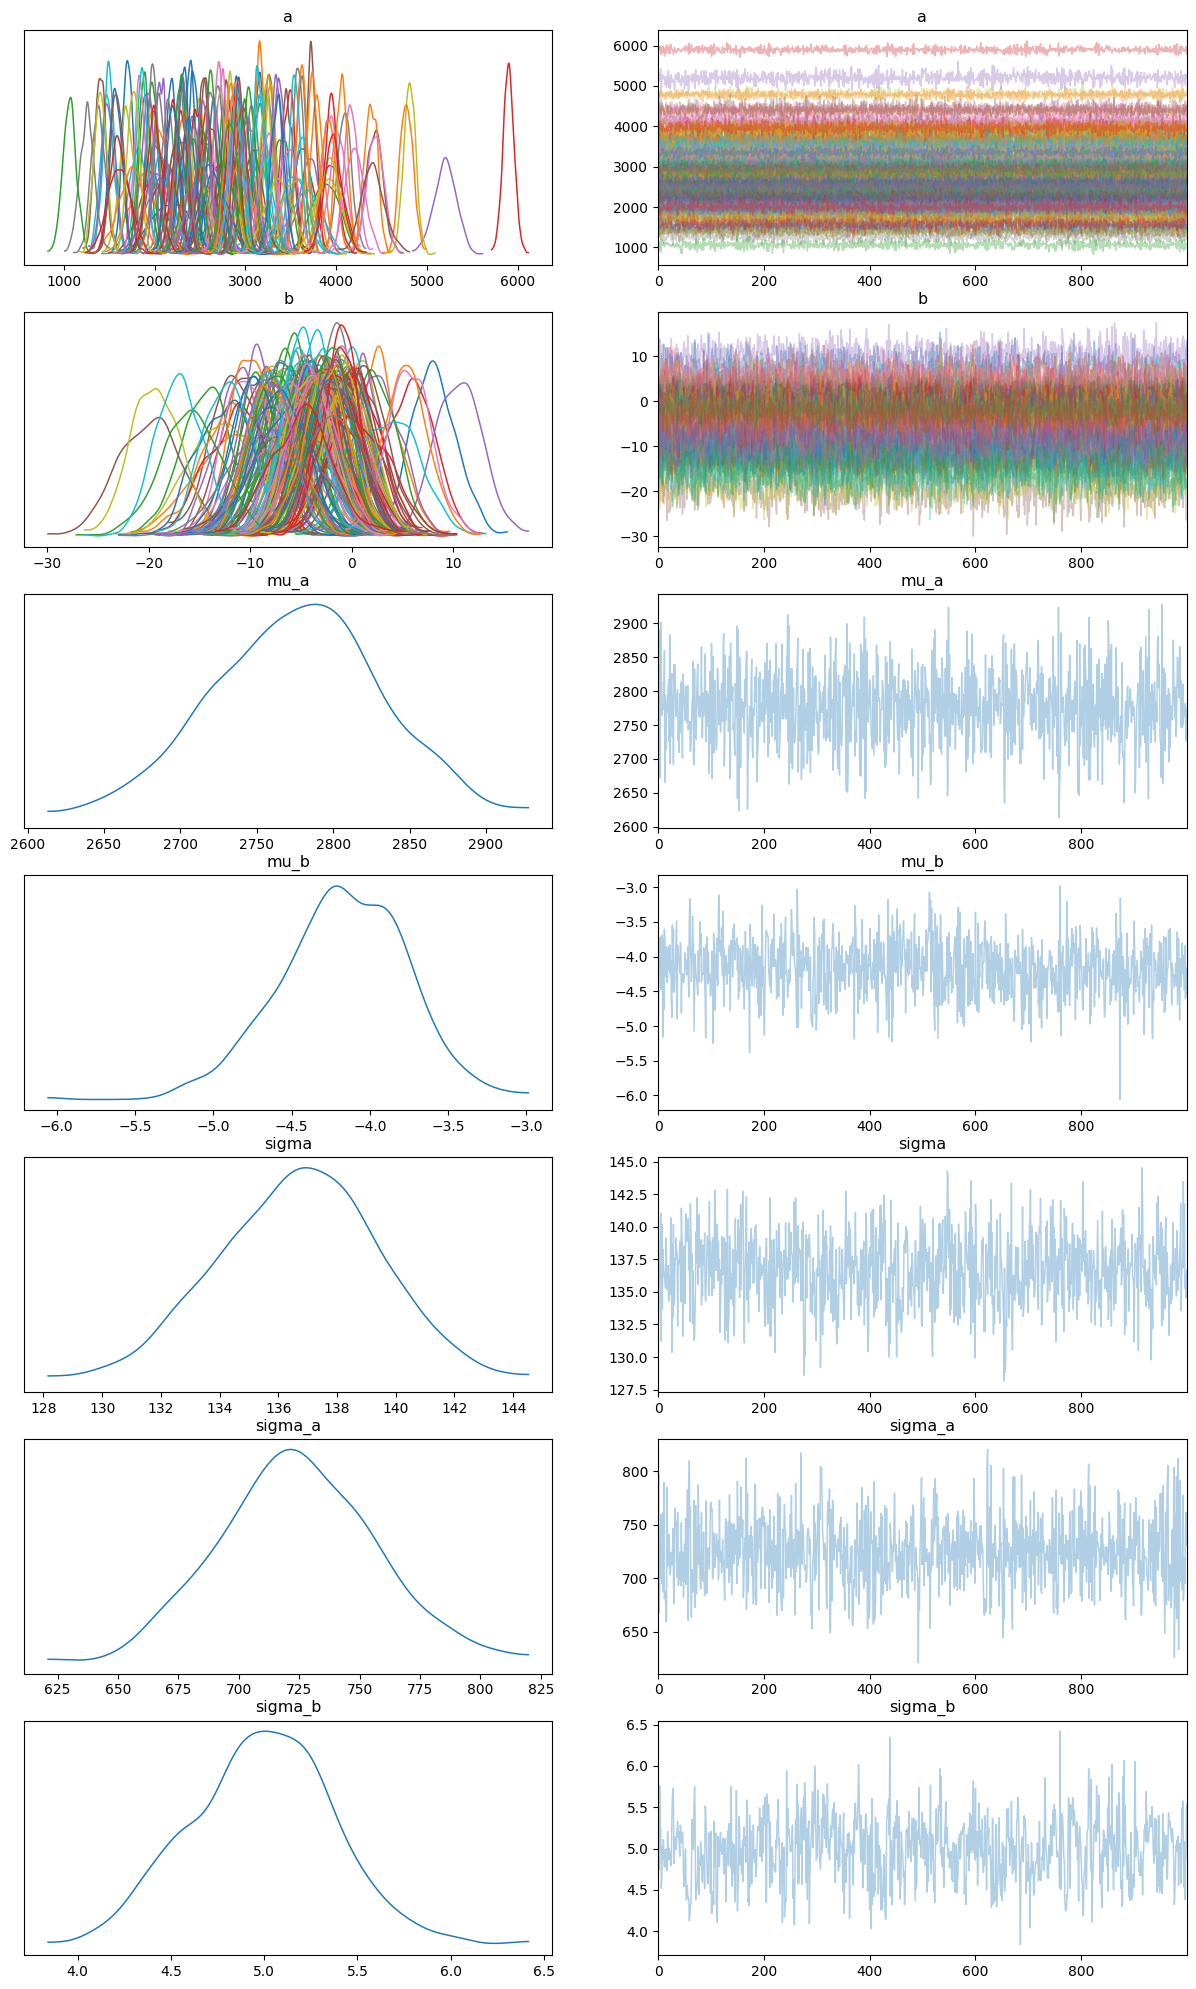

In [42]:
import arviz as az
idata = az.from_numpyro(mcmc)
az.plot_trace(idata, compact=True, figsize=(15, 25))

In [84]:
predictive = Predictive(hierarchical_linear_model, posterior_samples)
predictions = predictive(random.PRNGKey(2), patient_index, Weeks)

In [85]:
predictions['obs'].shape
mu_pred = jnp.mean(predictions['obs'], axis=0)
mu_pred.shape

(1549,)

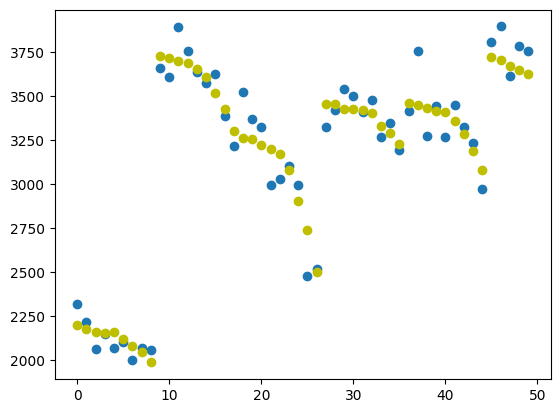

In [92]:
plt.scatter(range(50), FVC_obs[:50], marker='o')
plt.scatter(range(50), mu_pred[:50], marker='o', color='y')